# Coinflipping Zoo
- categories: [Julia, Turing]

Coinflipping is a time honored example for probability exercises, and for good reason. It is readily interpretable while providing ample opportunity for more complex scenarios. Nevermind that "unfair" coins are essentially impossible to make... In any case, a few examples of coin flipping!

In [8]:
#collapse
using Turing
using Gadfly
using DataFrames, DataFramesMeta

## Scenario: Trivial (Un)fair Coin
The simplest possible example: imagine we have a coin that might (or might not!) be fair. blah blah

In [2]:
@model function coinflip(y)
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p
    for i in 1:length(y)
        y[i] ~ Bernoulli(p)
    end
end

coinflip (generic function with 1 method)

In [138]:
data = [1,1,1,0,0,1,0,0,1,1,1,1,1,0,0,0]

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10

In [139]:
# Start sampling.
chain_bernoulli = sample(coinflip(data), HMC(ϵ, τ), iterations, progress=false);
chain_bernoulli

Chains MCMC chain (1000×10×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = p
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           p    0.5581    0.1148     0.0036    0.0048   373.2283    1.0029

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.3229    0.4873    0.5577    0.6392    0.7687


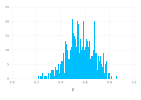

In [145]:
#collapse
plot(DataFrame(chain_bernoulli), x=:p, Geom.histogram)

Just to be clear, there are equivalent models that express the exact same underlying phenomena. Here's one example using `Binomial` in place of `Bernoulli`:

In [133]:
@model function coinflip_binomial(y)
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p
    heads = sum(y)
    heads ~ Binomial(length(y), p)
end

coinflip_binomial (generic function with 1 method)

In [134]:
chain_binomial = sample(coinflip(data), HMC(ϵ, τ), iterations, progress=false);
chain_binomial

Chains MCMC chain (1000×10×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = p
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           p    0.5655    0.1115     0.0035    0.0063   365.6428    1.0009

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.3448    0.4896    0.5702    0.6439    0.7724


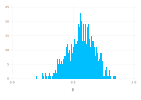

In [146]:
#collapse
plot(DataFrame(chain_binomial), x=:p, Geom.histogram)

## Scenario: Autocorrelation

Neato! So, the simplest case is pretty easy to work with. What about (moving past coin flipping to generic binary data) we have some data that has a *lot* of streaks (1, 1, 1, 1, 1, 1, ...)? Our estimates of `p` and our error terms will be wildly skewed (downward!) if we assume the data has independence. If for instance the data instead has autocorrelation (flipping a 1 is more likely if the preceeding flip was also a 1, and the reverse) then our estimates will just be wrong unless we account for it explicitly.

Let's generate some data in a way that very explicitly shows the connection to the previous datapoint:

In [122]:
data_autocor2 = [1]
p_1 = 0.85
p_2 = 0.15
for i in 2:1000
    if data_autocor2[i-1] == 1
        p = p_1
    else
        p = p_2
    end
    data_autocor2 = cat(data_autocor2, rand(Bernoulli(p)), dims=1)
end

And here's a model - it's not an accident that the model code looks so close to the data generating code!

In [141]:
@model function coinflip_autocor(y)
    # prior on p
    p_1 ~ Beta(1, 1)
    p_2 ~ Beta(1, 1)
    
    y[1] ~ Bernoulli(p_1)
    for i in 2:length(y)
        if y[i-1] == 1
            p = p_1
        else
            p = p_2
        end
        y[i] ~ Bernoulli(p)
    end
end

coinflip_autocor (generic function with 1 method)

In [142]:
#collapse
chain_autocor = sample(coinflip_autocor(data_autocor2), HMC(ϵ, τ), iterations, progress=false);
chain_autocor

Chains MCMC chain (1000×11×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = p_1, p_2
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

         p_1    0.8905    0.0231     0.0007    0.0002   4898.2965    0.9990
         p_2    0.1813    0.0297     0.0009    0.0004   4084.1890    0.9995

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         p_1    0.8640    0.8829    0.8913    0.8994    0.9159
         p_2    0.1349    0.1661    0.1803    0.1972    0.2265


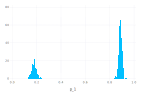

In [144]:
#collapse
plot(DataFrame(chain), layer(x=:p_1, Geom.histogram), layer(x=:p_2, Geom.histogram))

How to do this with an honest covariance matrix?
What about a "rich get richer" scenario? P(1) ~ b + length of streak of 1s
- would look good but how to diagnose issues?
    - distributions of streaks! a lot of extremely long streaks, a lot of short streaks... 

what about a "machine error" - double readings for both or one of 1s / 0s?

## Scenario: Rich get Richer
Look, we're long passed the physical analogy making sense for this data so just roll with it for now. The idea for this scenario is a minor extension of the former: every consecutive flip heads makes it more likely the next flip will also be heads, and the reverse for tails.

In [128]:
function streaks(arr)
    streaks = []
    val = arr[1]
    current_streak = 1
    for i in 2:length(arr)
        next_val = arr[i]
        if next_val == val
            current_streak = current_streak + 1
        else
            streaks = cat(streaks, current_streak, dims=1)
            val = next_val
            current_streak = 1
        end
    end
    streaks = cat(streaks, current_streak, dims=1)
    return streaks
end

streaks (generic function with 1 method)

In [129]:
streaks([1,1,1,1,2,2,2,2,3,2,1,2,2,2,1])

7-element Array{Any,1}:
 4
 4
 1
 1
 1
 3
 1

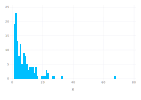

In [147]:
plot(DataFrame(x=streaks(data_autocor2)), x=:x, Geom.histogram)

## Scenario: Many Coins of Few Types

"data on several coins from specific mints. Coin of unknown origin with 10 flips, what is P(heads) on next flip?"

## Scenario: Coins with Continuous Bias

All coins come from one rather shitty mint. How shitty is that mint, and how shitty is this coin?

$$\mu_{mint} \sim \mathrm{Normal}(0,1)$$
$$\sigma_{mint} \sim \mathrm{Normal}(1, 2)$$

$$\mu_{coin} \sim \mathrm{Normal}(\mu_{mint}, \sigma_{mint})$$
$$ys \sim \mathrm{Bernoulli}(\mu_{coin})$$